In [50]:
import math
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

## 1. Preprocessing kWh Data

In [51]:
def preprocess_kwh(freq='D'):
    """
    Convert cumulative kWh readings to interval usage and aggregate.
    """
    df = pd.read_csv(
        "../data/og_data/Energie_KWh_15_min.csv",
        delimiter=";",
        parse_dates=["timestamp"],
        dayfirst=True,
        na_values="NULL"
    )
    numeric_cols = df.columns.drop("timestamp")
    df[numeric_cols] = (
        df[numeric_cols]
          .astype(float)
          .ffill()
          .diff()
          .clip(lower=0, upper=200)
          .fillna(0)
    )
    df = df.set_index("timestamp").resample(freq).sum().reset_index()
    df["timestamp"] = df["timestamp"].dt.normalize()
    return df

## 2. Preprocessing Frequency Data

In [52]:
def preprocess_freq(freq='D'):
    """
    Read, rename & reorder all frequentie columns, then interpolate to match kWh freq.
    Returns a DataFrame with ['timestamp','frequentie'].
    """
    df = pd.read_csv(
        "../data/og_data/frequentie.csv",
        delimiter=";",
        parse_dates=["interval_15min"],
        dayfirst=True,
        na_values="NULL"
    )

    # Rename every v_* → human label
    col_mapping = {
        'interval_15min':       'timestamp',
        'v_19':                 'Toevoer toren 1',
        'v_84':                 'Afvoer toren 1',
        'v_260':                'Toevoer toren 3',
        'v_261':                'Afvoer toren 3',
        'v_287':                'Toevoer toren 2',
        'v_472':                'Afvoer toren 2',
        'v_595':                'Afvoer toren 4',
        'v_685':                'Toevoer toren 5',
        'v_819':                'Afvoer toren 5',
        'v_835':                'Toevoer toren 4',
        'v_984':                'Toevoer toren 6',
        'v_1111':               'Afvoer toren 6',
        'v_1203':               'Toevoer toren 7',
        'v_1216':               'Afvoer toren 7',
        'v_1320':               'Toevoer toren 8',
        'v_1329':               'Toevoer bijgebouw',
        'v_1550':               'Afvoer toren 8',
        'v_1631':               'Afvoer bijgebouw',
        'v_1676':               'Toevoer vergadercentrum',
        'v_1678':               'Afvoer vergadercentrum',
        'v_1988':               'Afvoer auditorium',
        'v_2069':               'Afvoer 1 keuken',
        'v_2111':               'Toevoer auditorium',
        'v_2168':               'Afvoer 2 keuken',
        'v_2209':               'Toevoer keuken'
    }
    df = df.rename(columns=col_mapping)

    # Reorder columns to match kWh layout
    desired_order = [
        'timestamp',
        'Toevoer toren 1',
        'Afvoer toren 1',
        'Afvoer toren 3',
        'Toevoer toren 2',
        'Afvoer toren 2',
        'Toevoer toren 3',
        'Afvoer toren 4',
        'Toevoer toren 5',
        'Afvoer toren 5',
        'Toevoer toren 4',
        'Toevoer toren 7',
        'Toevoer toren 6',
        'Afvoer toren 6',
        'Afvoer toren 7',
        'Afvoer toren 8',
        'Toevoer toren 8',
        'Toevoer bijgebouw',
        'Afvoer bijgebouw',
        'Afvoer vergadercentrum',
        'Toevoer vergadercentrum',
        'Afvoer 1 keuken',
        'Toevoer auditorium',
        'Afvoer auditorium',
        'Toevoer keuken',
        'Afvoer 2 keuken'
    ]
    df = df[desired_order]

    # Drop duplicates, align to freq, interpolate, normalize
    df = df.drop_duplicates(subset="timestamp")
    df = (
        df.set_index("timestamp")
          .asfreq(freq)
          .interpolate()
          .reset_index()
    )
    df["timestamp"] = df["timestamp"].dt.normalize()

    # Keep only the primary frequency series
    df = df.rename(columns={'Toevoer toren 1': 'frequentie'})
    return df[['timestamp', 'frequentie']]

## 3. Forecast Efficiency with Prophet

In [53]:
def forecast_efficiency(freq='W', train_start=None):
    """
    Forecast kWh channels separately with Prophet, using 'frequentie' as regressor,
    and skip certain columns from the average MAE% and R².
    """
    kwh_df = preprocess_kwh(freq)
    freq_df = preprocess_freq(freq)
    df = pd.merge(kwh_df, freq_df, on="timestamp", how="inner").rename(columns={"timestamp": "ds"})

    train_end      = pd.to_datetime("2024-06-04")
    train_start_dt = pd.to_datetime(train_start) if train_start else df["ds"].min()
    test_start     = train_end + pd.Timedelta(days=1)

    kwh_cols = kwh_df.columns.drop("timestamp")
    n_cols, n_rows = 2, math.ceil(len(kwh_cols) / 2)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axs = axs.reshape(n_rows, n_cols)

    metrics = []
    for idx, col in enumerate(kwh_cols):
        if col.lower() == "afvoer toren 5":
            continue

        row, col_idx = divmod(idx, n_cols)
        ax = axs[row, col_idx]

        data = (
            df[["ds", col, "frequentie"]]
              .rename(columns={col: "y"})
              .sort_values("ds")
              .copy()
        )
        data["frequentie"] = data["frequentie"].replace(0, np.nan).ffill().bfill().fillna(0)
        if data["y"].nunique() <= 1:
            ax.axis('off'); continue

        train = data[(data["ds"] >= train_start_dt) & (data["ds"] <= train_end)]
        test  = data[data["ds"] >= test_start]
        if train.empty or test.empty:
            ax.axis('off'); continue

        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
        m.add_regressor("frequentie")
        m.fit(train)

        future = m.make_future_dataframe(periods=len(test), freq=freq)
        future = future.merge(data[["ds","frequentie"]], on="ds", how="left")
        future["frequentie"] = future["frequentie"].ffill().bfill().fillna(0)

        fc = m.predict(future)
        fc[["yhat","yhat_lower","yhat_upper"]] = fc[["yhat","yhat_lower","yhat_upper"]].clip(lower=0)

        merged = test.merge(fc[["ds","yhat"]], on="ds")
        y_true, y_pred = merged["y"].values, merged["yhat"].values
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        mae_pct = mae / np.mean(y_true) * 100
        metrics.append((col, mae, r2, mae_pct))

        m.plot(fc, ax=ax)
        ax.set_title(
            f"{col} (Train {train_start_dt.date()}–{train_end.date()})\n"
            f"MAE: {mae:.2f} ({mae_pct:.1f}%), R²: {r2:.2f}"
        )

    # turn off any unused axes
    for i in range(len(kwh_cols), n_rows * n_cols):
        r, c = divmod(i, n_cols)
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.show()

    # — exclude these from the average —
    skip = {
        'Toevoer toren 7',
        'Afvoer toren 7',
        'Toevoer auditorium',
        'Afvoer auditorium'
    }
    filtered = [m for m in metrics if m[0] not in skip]

    # print all individual metrics
    print("\nEfficiency Forecast Metrics:")
    for col, mae, r2, mae_pct in metrics:
        print(f"  {col}: MAE={mae:.2f} ({mae_pct:.1f}%), R²={r2:.2f}")

    # compute and print averages over the filtered set
    avg_mae_pct = np.mean([m[3] for m in filtered])
    avg_r2      = np.mean([m[2] for m in filtered])
    print(f"\nAverage MAE% (excl. {', '.join(skip)}): {avg_mae_pct:.1f}%")
    print(f"Average R²   (excl. {', '.join(skip)}): {avg_r2:.2f}")

# Efficiency Daily

19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:24 - cmdstanpy - INFO - Chain [1] start processing
19:00:24 - cmdstanpy - INFO - Chain [1] done processing
19:00:24 - cmdstanpy - INFO - Chain [1] start processing
19:00:24 - cmdstanpy - INFO - Chain [1] done processing
19:00:24 - cmdstanpy - INFO - Chain [1] start processing
19:00:24 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:26 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1]

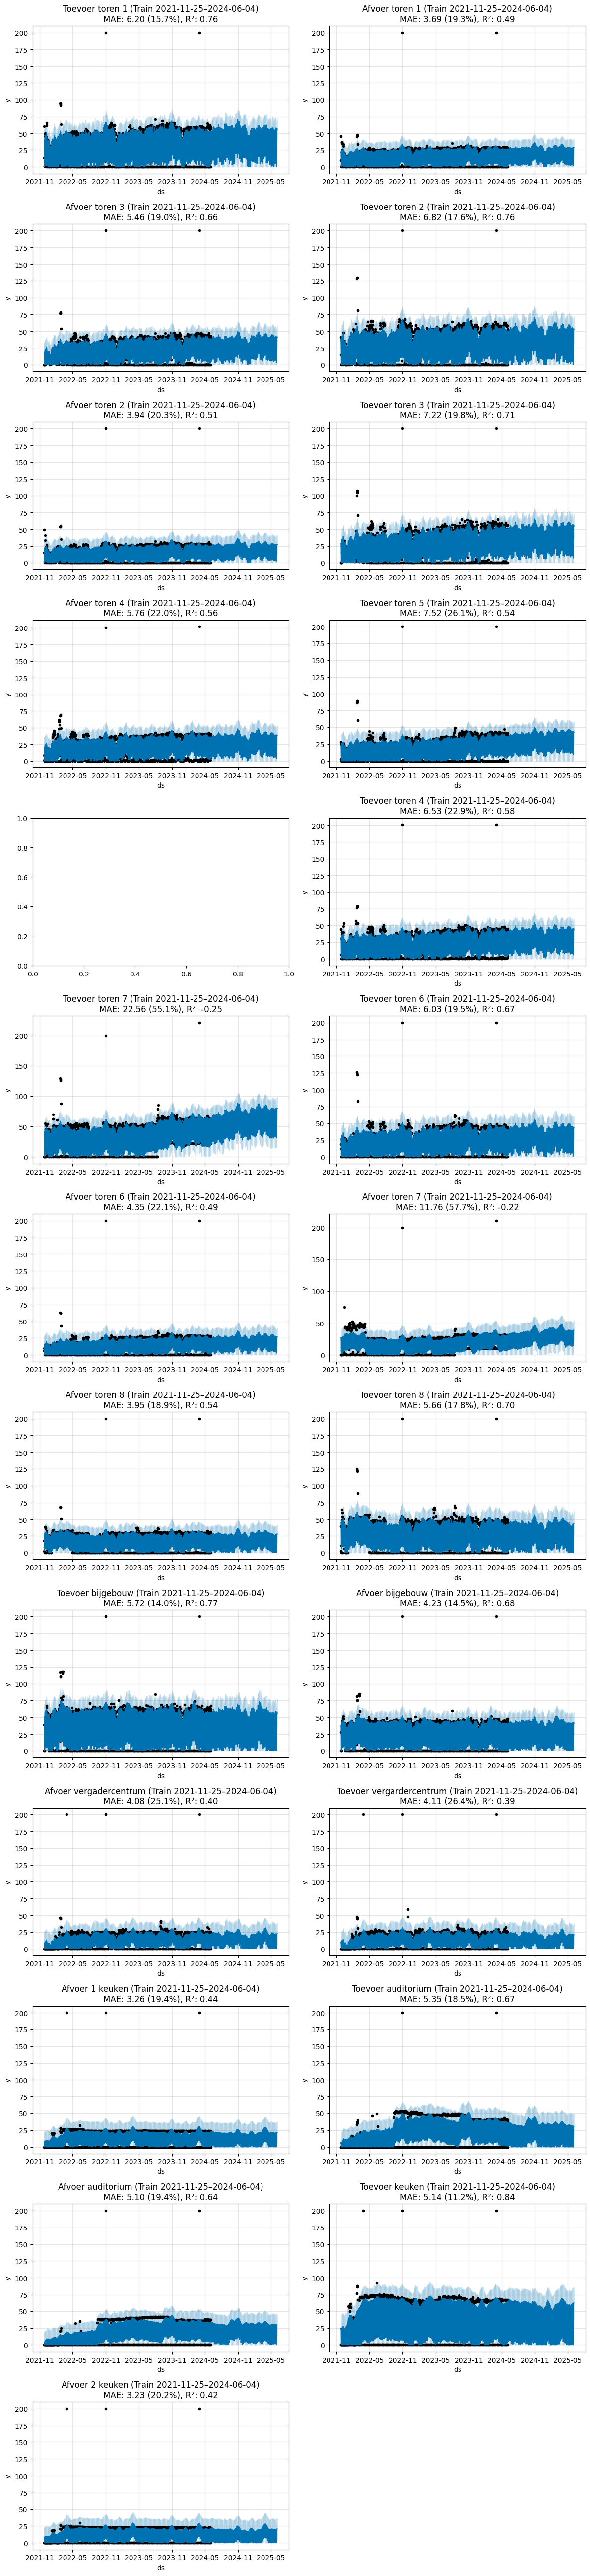


Efficiency Forecast Metrics:
  Toevoer toren 1: MAE=6.20 (15.7%), R²=0.76
  Afvoer toren 1: MAE=3.69 (19.3%), R²=0.49
  Afvoer toren 3: MAE=5.46 (19.0%), R²=0.66
  Toevoer toren 2: MAE=6.82 (17.6%), R²=0.76
  Afvoer toren 2: MAE=3.94 (20.3%), R²=0.51
  Toevoer toren 3: MAE=7.22 (19.8%), R²=0.71
  Afvoer toren 4: MAE=5.76 (22.0%), R²=0.56
  Toevoer toren 5: MAE=7.52 (26.1%), R²=0.54
  Toevoer toren 4: MAE=6.53 (22.9%), R²=0.58
  Toevoer toren 7: MAE=22.56 (55.1%), R²=-0.25
  Toevoer toren 6: MAE=6.03 (19.5%), R²=0.67
  Afvoer toren 6: MAE=4.35 (22.1%), R²=0.49
  Afvoer toren 7: MAE=11.76 (57.7%), R²=-0.22
  Afvoer toren 8: MAE=3.95 (18.9%), R²=0.54
  Toevoer toren 8: MAE=5.66 (17.8%), R²=0.70
  Toevoer bijgebouw: MAE=5.72 (14.0%), R²=0.77
  Afvoer bijgebouw: MAE=4.23 (14.5%), R²=0.68
  Afvoer vergadercentrum: MAE=4.08 (25.1%), R²=0.40
  Toevoer vergardercentrum: MAE=4.11 (26.4%), R²=0.39
  Afvoer 1 keuken: MAE=3.26 (19.4%), R²=0.44
  Toevoer auditorium: MAE=5.35 (18.5%), R²=0.67
  Afvo

In [54]:
forecast_efficiency(freq='D', train_start=None)

# Efficiency Weekly

19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] done processing
19:00:34 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1]

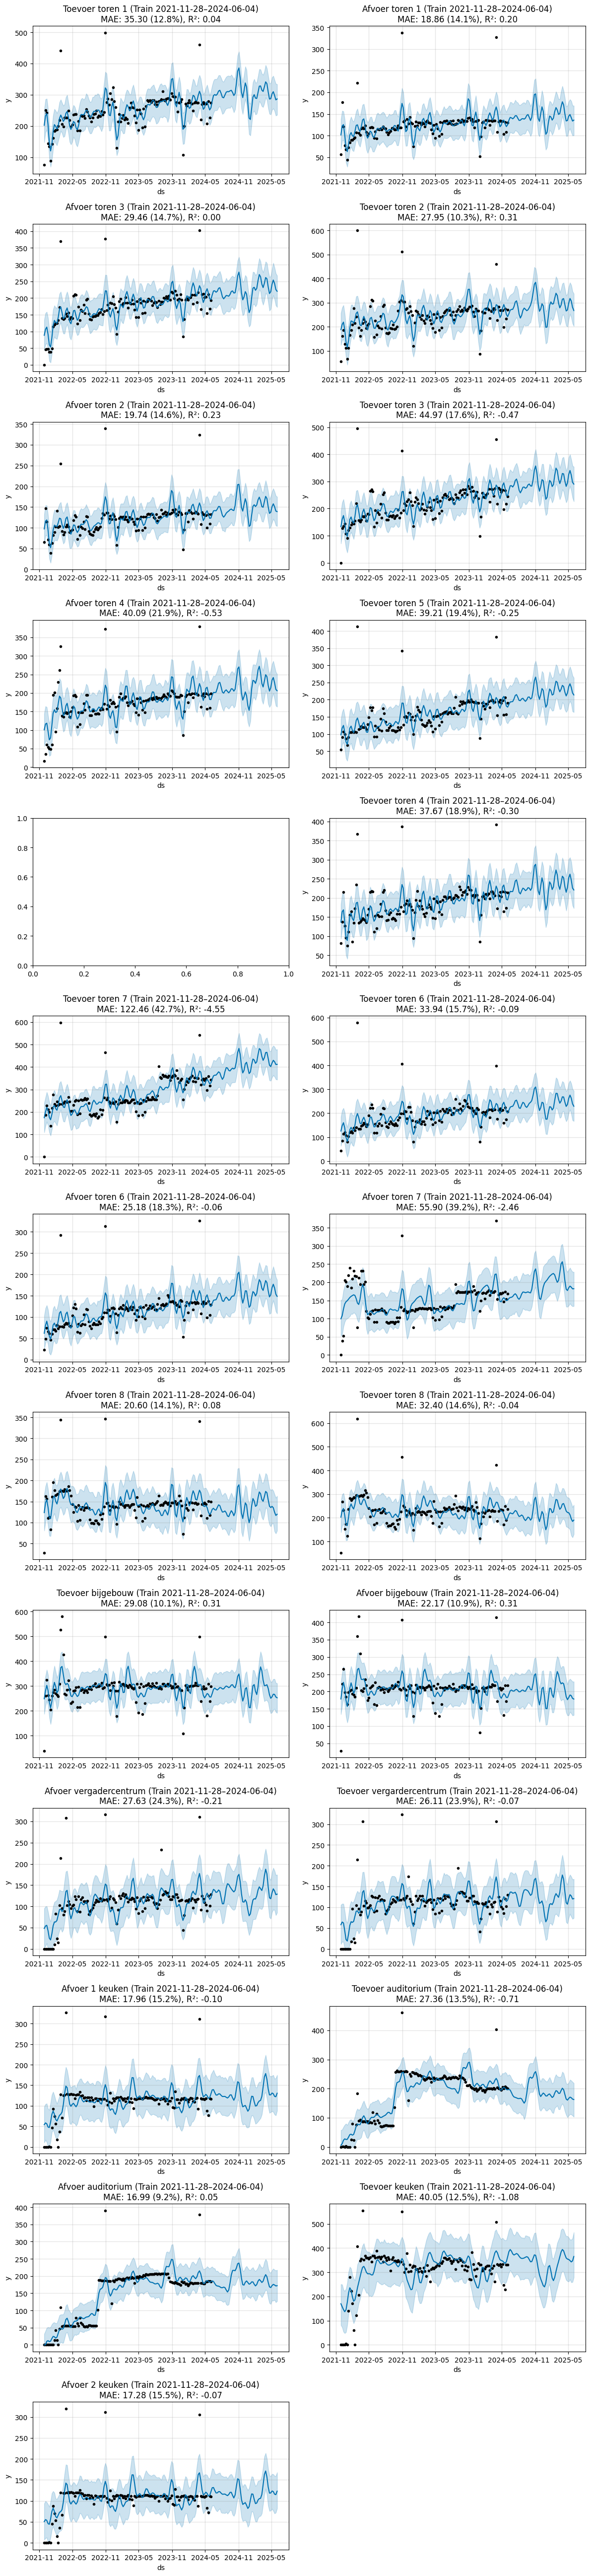


Efficiency Forecast Metrics:
  Toevoer toren 1: MAE=35.30 (12.8%), R²=0.04
  Afvoer toren 1: MAE=18.86 (14.1%), R²=0.20
  Afvoer toren 3: MAE=29.46 (14.7%), R²=0.00
  Toevoer toren 2: MAE=27.95 (10.3%), R²=0.31
  Afvoer toren 2: MAE=19.74 (14.6%), R²=0.23
  Toevoer toren 3: MAE=44.97 (17.6%), R²=-0.47
  Afvoer toren 4: MAE=40.09 (21.9%), R²=-0.53
  Toevoer toren 5: MAE=39.21 (19.4%), R²=-0.25
  Toevoer toren 4: MAE=37.67 (18.9%), R²=-0.30
  Toevoer toren 7: MAE=122.46 (42.7%), R²=-4.55
  Toevoer toren 6: MAE=33.94 (15.7%), R²=-0.09
  Afvoer toren 6: MAE=25.18 (18.3%), R²=-0.06
  Afvoer toren 7: MAE=55.90 (39.2%), R²=-2.46
  Afvoer toren 8: MAE=20.60 (14.1%), R²=0.08
  Toevoer toren 8: MAE=32.40 (14.6%), R²=-0.04
  Toevoer bijgebouw: MAE=29.08 (10.1%), R²=0.31
  Afvoer bijgebouw: MAE=22.17 (10.9%), R²=0.31
  Afvoer vergadercentrum: MAE=27.63 (24.3%), R²=-0.21
  Toevoer vergardercentrum: MAE=26.11 (23.9%), R²=-0.07
  Afvoer 1 keuken: MAE=17.96 (15.2%), R²=-0.10
  Toevoer auditorium: MAE

In [55]:
forecast_efficiency(freq='W')